<a href="https://colab.research.google.com/github/Pratham-04/CS786A-Spring-2020-21/blob/main/Project/Code/Estimate_Parameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pykalman
!pip install constrNMPy

     |████████████████████████████████| 235kB 5.3MB/s 
  Created wheel for pykalman: filename=pykalman-0.9.5-cp37-none-any.whl size=48464 sha256=026f602f7b742a33c25617374be00ba0934fdb92a23674a0f2a5b094d8d6aa6e
  Stored in directory: /root/.cache/pip/wheels/d9/e8/6a/553d9832679cb74a8434fa597c3abdb07313e40054a0adf9ac
Successfully built pykalman


In [ ]:
import numpy as np
import pandas as pd
import io
import scipy.optimize as opt
from scipy.stats.mvn import mvnun
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import constrNMPy as cNM
import json
import pickle
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [ ]:
from google.colab import files

In [ ]:
def makeRew(trend, stable, clip, numTrials, s):
    # generates the game and returns those where each bandit is the best at least once
    np.random.seed(s)
    
    # initializations
    mus = []
    rews = []
    mu = np.array([-60, -20, 20, 60])
    np.random.shuffle(mu)
    mus.append(mu)
    sigma1 = 4
    decay = 0.9836
    
    # trend
    kappas = np.zeros(4)
    if trend == 1:
        kappas[mu > 0] = -0.5
        kappas[mu < 0] = 0.5

    # stable/variable            
    sigma2 = 4        
    rews.append(np.random.normal(mu, sigma2))           
    for i in range(numTrials - 1):
        if stable == 0 and (51<=i<=100 or 151<=i<=200):
            sigma2 = 16
        else:
            sigma2 = 4
        mu = np.multiply(mu, decay)
        mu = np.add(mu, kappas)
        mu = np.random.normal(mu, sigma2)
        if clip == 1:
            mu = np.clip(mu, -100, 100)
        mus.append(mu)
        
        rew = np.random.normal(mu, sigma1)
        if clip == 1:
            rew = np.clip(rew, -100, 100)
        rews.append(rew)
    np.random.seed(None)
    maxs = np.argmax(rews, 1)
    if ((0 in maxs) and (1 in maxs) and (2 in maxs) and (3 in maxs)):
        return np.array(mus), np.array(rews)
    else:
        return None, None

In [ ]:
# utility from prospect theory

def util(r, lamb, alpha):
    # print(r)
    u = np.copy(r)
    u[r >= 0] = u[r >= 0]**alpha
    u[r < 0] = -lamb*((-u[r < 0])**alpha)
    return u

In [ ]:
# choice rules

def dyn_softmax(x, temp0, i):
    temp = ((i+1)/10)**temp0
    return np.exp(np.multiply(x,temp))/np.sum(np.exp(np.multiply(x,temp)))

def softmax(x, temp):
    return np.exp(np.multiply(x,temp))/np.sum(np.exp(np.multiply(x,temp)))

def pmu(x_mean, x_var, sigma_eps):
    prob = -1*np.ones(4)
    for i in range(4):
        A = -1*np.identity(3)
        A = np.insert(A, i, np.array([1,1,1]), 1)
        M = np.matmul(A, x_mean)
        H = np.diag(x_var + sigma_eps**2)
        H = np.matmul(np.matmul(A, H), np.transpose(A))
        prob[i] = mvnun([0,0,0], [np.inf,np.inf,np.inf], M, H)[0]
    return prob/np.sum(prob)

In [ ]:
# learning rules

def delta(x, rew, choice, eta, lamb, alpha):
    lr = np.zeros(4)
    lr[choice] = eta
    return x + np.multiply(lr, util(rew, lamb, alpha) - x)

def decay(x, rew, choice, eta_dec, lamb, alpha):
    y = np.zeros(4)
    y[choice] = 1
    return eta_dec*x + np.multiply(y, util(rew, lamb, alpha))

def kalman(x_mean, x_var, rew, choice, sigma_xi, sigma_eps, lamb, alpha):
    k_gain = np.zeros(4)
    k_gain[choice] = (x_var[choice] + sigma_xi**2)/(x_var[choice] + sigma_xi**2 + sigma_eps**2)
    x_mean1 = x_mean + np.multiply(k_gain, util(rew, lamb, alpha) - x_mean)
    x_var1 = np.multiply(1 - k_gain, x_var + sigma_xi**2)
    return x_mean1, x_var1

In [ ]:
# likelihood estimators

def del_dsm_neglik(param, rews, chosen_idx):
    numTrials = rews.shape[0]
    temp0 = param[0]
    mu0 = param[1]
    eta = param[2]
    lamb = param[3]
    alpha = param[4]
    m = mu0*np.ones((numTrials + 1, 4))
    loglik = 0
    for i in range(numTrials):
        prob = dyn_softmax(m[i], temp0, i)
        m[i+1] = delta(m[i], rews[i], int(chosen_idx[i]), eta, lamb, alpha)
        loglik += np.log(prob[int(chosen_idx[i])])
    return -loglik

def dec_fsm_neglik(param, rews, chosen_idx):
    temp = param[0]
    mu0 = param[1]
    eta_dec = param[2]
    lamb = param[3]
    alpha = param[4]
    numTrials = rews.shape[0]
    m = mu0*np.ones((numTrials+1, 4))
    loglik = 0
    for i in range(numTrials):
        prob = softmax(m[i], temp)
        m[i+1] = decay(m[i], rews[i], int(chosen_idx[i]), eta_dec, lamb, alpha)
        loglik += np.log(prob[int(chosen_idx[i])])
    return -loglik

def kf_pmu_neglik(param, rews, chosen_idx):
    numTrials = rews.shape[0]
    mu0 = param[0]
    sigma0 = param[1]
    sigma_xi = param[2]
    sigma_eps = param[3]
    lamb = param[4]
    alpha = param[5]
    m = mu0*np.ones((numTrials + 1, 4))
    v = sigma0*np.ones((numTrials + 1, 4))
    loglik = 0
    for i in range(numTrials):
        prob = pmu(m[i], v[i], sigma_eps)
        m[i+1], v[i+1] = kalman(m[i], v[i], rews[i], int(chosen_idx[i]), sigma_xi, sigma_eps, lamb, alpha)
        loglik += np.log(prob[int(chosen_idx[i])])
    return -loglik

def null_neglik(param, rews, chosen_idx):
    numTrials = rews.shape[0]
    p = param[0]
    q = param[1]
    r = param[2]
    s = 1 - p - q - r
    x = np.array([p, q, r, s])
    loglik = 0
    for i in range(numTrials):
        loglik += np.log(x[int(chosen_idx[i])])
    return -loglik

In [ ]:
# fitting scores

def delta_aic(id, param_1, param_2, rews, chosen_idx):
    num1 = param_1.size
    num2 = param_2.size
    lik2 = -null_neglik(param_2, rews, chosen_idx)
    if id == 'kf_pmu':
        lik1 = -kf_pmu_neglik(param_1, rews, chosen_idx)
    elif id == 'dec_smf':
        lik1 = -dec_fsm_neglik(param_1, rews, chosen_idx)
    elif id == 'del_smd':
        lik1 = -del_dsm_neglik(param_1, rews, chosen_idx)
    aic1 = 2*(num1 - lik1)
    aic2 = 2*(num2 - lik2)
    return aic1, aic2, aic2 - aic1

def delta_bic(id, param_1, param_2, rews, chosen_idx, samp):
    num1 = param_1.size
    num2 = param_2.size
    lik2 = -null_neglik(param_2, rews, chosen_idx)
    if id == 'kf_pmu':
        lik1 = -kf_pmu_neglik(param_1, rews, chosen_idx)
    elif id == 'dec_smf':
        lik1 = -dec_fsm_neglik(param_1, rews, chosen_idx)
    elif id == 'del_smd':
        lik1 = -del_dsm_neglik(param_1, rews, chosen_idx)
    bic1 = num1*np.log(samp) - 2*lik1
    bic2 = num2*np.log(samp) - 2*lik2
    return bic1, bic2, bic2 - bic1

In [ ]:
# trend, stable
numTrials = 200
m000, r000 = makeRew(0, 0, 0, numTrials, 207)
m001, r001 = makeRew(0, 0, 0, numTrials, 368)
m010, r010 = makeRew(0, 1, 0, numTrials, 82)
m011, r011 = makeRew(0, 1, 0, numTrials, 411)
m100, r100 = makeRew(1, 0, 0, numTrials, 49)
m101, r101 = makeRew(1, 0, 0, numTrials, 67)
m110, r110 = makeRew(1, 1, 0, numTrials, 75)
m111, r111 = makeRew(1, 1, 0, numTrials, 287)

Text(0.04, 0.5, 'Reward')

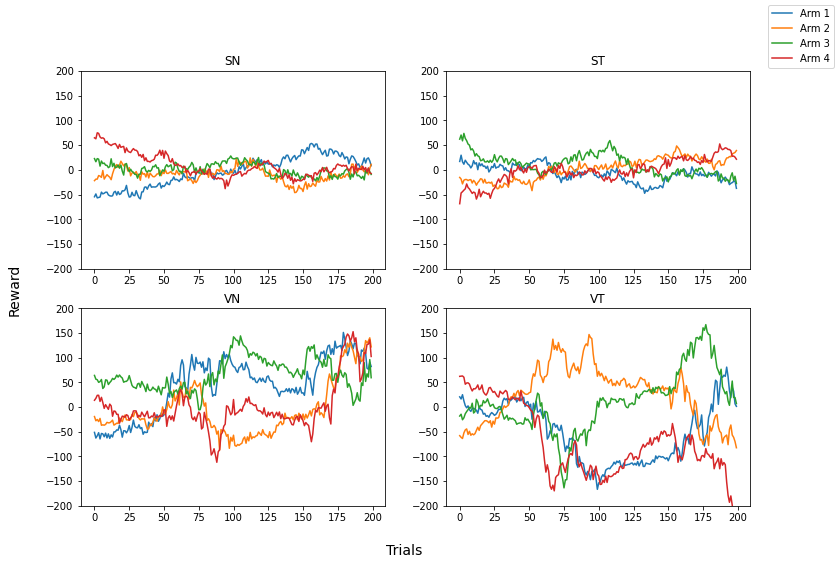

In [ ]:
fig , axs = plt.subplots(ncols = 2, nrows = 2, figsize = (12,8))

axs[0, 0].plot(r010)
axs[0, 0].set_ylim(-200, 200)
axs[0, 1].plot(r110)
axs[0, 1].set_ylim(-200, 200)
axs[1, 0].plot(r000)
axs[1, 0].set_ylim(-200, 200)
axs[1, 1].plot(r101)
axs[1, 1].set_ylim(-200, 200)
axs[0, 0].set_title('SN')
axs[0, 1].set_title('ST')
axs[1, 0].set_title('VN')
axs[1, 1].set_title('VT')
fig.legend(labels = ['Arm 1', 'Arm 2', 'Arm 3', 'Arm 4'])

fig.text(0.5, 0.04, 'Trials', ha = 'center', fontsize = 14)
fig.text(0.04, 0.5, 'Reward', va='center', rotation='vertical', fontsize = 14)

In [ ]:
uploaded = files.upload()

Saving 32.csv to 32.csv
Saving 41.csv to 41.csv
Saving 51.csv to 51.csv
Saving 52.csv to 52.csv
Saving 57.csv to 57.csv
Saving 63.csv to 63.csv
Saving 73.csv to 73.csv
Saving 76.csv to 76.csv
Saving 81.csv to 81.csv
Saving 85.csv to 85.csv
Saving 86.csv to 86.csv
Saving 90.csv to 90.csv
Saving 91.csv to 91.csv
Saving 98.csv to 98.csv
Saving 99.csv to 99.csv
Saving 125.csv to 125.csv
Saving 139.csv to 139.csv
Saving 140.csv to 140.csv
Saving 143.csv to 143.csv
Saving 148.csv to 148.csv
Saving 149.csv to 149.csv
Saving 150.csv to 150.csv
Saving 152.csv to 152.csv
Saving 156.csv to 156.csv
Saving 159.csv to 159.csv
Saving 161.csv to 161.csv
Saving 163.csv to 163.csv
Saving 169.csv to 169.csv
Saving 170.csv to 170.csv
Saving 178.csv to 178.csv


In [ ]:
params_null = []
params_del_smd = []
params_dec_smf = []
params_kf_pmu = []

num_sheet = []

del_aics1 = []
del_bics1 = []
del_aics2 = []
del_bics2 = []
del_aics3 = []
del_bics3 = []

numTrials = 200

for i in range(200):
    if (str(i) + '.csv') in uploaded:
        df = pd.read_csv(io.BytesIO(uploaded[str(i) + '.csv']))
        if df.shape[0] > 575:
            num_sheet.append(i)
            print(i)
            
            trend = df['trend'][1]
            stable = df['stable'][1]
            num = df['num'][1]
            resp_map = eval(df['resp_map'][1])

            pinfo = json.loads(df['response'][0])
            age = pinfo['age']
            sex = pinfo['sex']
            hand = pinfo['hand']

            chosen_idx = df['response']
            chosen_idx = chosen_idx.iloc[6:df.shape[0]]
            chosen_idx = chosen_idx[[i for i in range(6, df.shape[0], 3)]]
            chosen_idx[chosen_idx == 'q'] = resp_map[0]
            chosen_idx[chosen_idx == 'p'] = resp_map[1]
            chosen_idx[chosen_idx == 'm'] = resp_map[2]
            chosen_idx[chosen_idx == 'z'] = resp_map[3]
            chosen_idx[pd.isna(chosen_idx)] = -1
            chosen_idx = np.array(chosen_idx)

            rews = eval('r' + str(trend) + str(stable) + str(num))
            rews = rews[0:chosen_idx.shape[0],:]
            rews = rews[chosen_idx != -1]
            chosen_idx = chosen_idx[chosen_idx != -1]

            samp = rews.shape[0]

            LB = [0, 0, 0]
            UB = [1, 1, 1]
            param = np.array([0.1, 0.1, 0.1])
            ans = cNM.constrNM(null_neglik, param, LB, UB, args = (rews, chosen_idx,), full_output = True)
            param_2 = ans['xopt']
            params_null.append(param_2)

            LB = [0.01, 0, 0, 0, 0]
            UB = [2, 5000, 1, 2, 2]
            param = np.array([0.1, 0.1, 0.5, 1, 1])
            ans = cNM.constrNM(del_dsm_neglik, param, LB, UB, args = (rews, chosen_idx,), full_output = True)
            param_1 = ans['xopt']
            params_del_smd.append(param_1)
            id = 'del_smd'
            print(id)
            a, b, c = delta_aic(id, param_1, param_2, rews, chosen_idx)
            d, e, f = delta_bic(id, param_1, param_2, rews, chosen_idx, samp)
            del_aics1.append(c)
            del_bics1.append(f)

            LB = [0.01, 0, 0, 0, 0]
            UB = [1, 1, 1, 3, 3]
            param = np.array([0.1, 0.1, 0.5, 1, 1])
            ans = cNM.constrNM(dec_fsm_neglik, param, LB, UB, args = (rews, chosen_idx,), full_output = True)
            param_1 = ans['xopt']
            params_dec_smf.append(param_1)
            id = 'dec_smf'
            print(id)
            a, b, c = delta_aic(id, param_1, param_2, rews, chosen_idx)
            d, e, f = delta_bic(id, param_1, param_2, rews, chosen_idx, samp)
            del_aics2.append(c)
            del_bics2.append(f)

            LB = [0, 0, 0, 0, 0, 0]
            UB = [10, 2000, 2000, 2000, 3, 3]
            param = np.array([0.1, 2, 0.5, 1, 1, 1])
            ans = cNM.constrNM(kf_pmu_neglik, param, LB, UB, args = (rews, chosen_idx,), full_output = True)
            param_1 = ans['xopt']
            params_kf_pmu.append(param_1)
            id = 'kf_pmu'
            print(id)
            a, b, c = delta_aic(id, param_1, param_2, rews, chosen_idx)
            d, e, f = delta_bic(id, param_1, param_2, rews, chosen_idx, samp)
            del_aics3.append(c)
            del_bics3.append(f)

32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


del_smd
dec_smf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log


kf_pmu
41
del_smd
dec_smf
kf_pmu
51
del_smd
dec_smf
kf_pmu
52


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


del_smd
dec_smf
kf_pmu
57
del_smd
dec_smf
kf_pmu
63
del_smd
dec_smf
kf_pmu
73
del_smd
dec_smf
kf_pmu
76
del_smd
dec_smf
kf_pmu
81
del_smd
dec_smf
kf_pmu
85
del_smd
dec_smf
kf_pmu
86
del_smd
dec_smf
kf_pmu
90
del_smd
dec_smf
kf_pmu
91
del_smd
dec_smf
kf_pmu
98
del_smd
dec_smf
kf_pmu
99
del_smd
dec_smf
kf_pmu
125
del_smd
dec_smf
kf_pmu
139
del_smd
dec_smf
kf_pmu
140
del_smd
dec_smf
kf_pmu
143
del_smd
dec_smf
kf_pmu
148
del_smd
dec_smf
kf_pmu
149
del_smd
dec_smf
kf_pmu
150
del_smd
dec_smf
kf_pmu
152
del_smd
dec_smf
kf_pmu
156
del_smd
dec_smf
kf_pmu
159
del_smd
dec_smf
kf_pmu
161
del_smd
dec_smf
kf_pmu
163
del_smd
dec_smf
kf_pmu
169
del_smd
dec_smf
kf_pmu
170
del_smd
dec_smf
kf_pmu
178
del_smd
dec_smf
kf_pmu


In [ ]:
num_tot = len(num_sheet)
prob1_aic = np.zeros(num_tot)
prob2_aic = np.zeros(num_tot)
prob3_aic = np.zeros(num_tot)
prob1_bic = np.zeros(num_tot)
prob2_bic = np.zeros(num_tot)
prob3_bic = np.zeros(num_tot)

n_aic = []
n_bic = []

for i in range(num_tot):
    x = np.array([del_aics1[i], del_aics2[i], del_aics3[i]])
    y = np.array([del_bics1[i], del_bics2[i], del_bics3[i]])
    n_aic.append(np.argmax(x))
    n_bic.append(np.argmax(y))

    [prob1_aic[i], prob2_aic[i], prob3_aic[i]] = softmax(x, -0.5)
    [prob1_bic[i], prob2_bic[i], prob3_bic[i]] = softmax(y, -0.5)

In [ ]:
print('For Delta & Dynamic Softmax')
print('Mean Δ(AIC) = ' + str(np.mean(del_aics1)))
print('Stdev Δ(AIC) = ' + str(np.std(del_aics1)))
print('Mean w(AIC) = ' + str(np.mean(prob1_aic)))
print('Stdev w(AIC) = ' + str(np.std(prob1_aic)))
print('n(AIC) = ' + str(n_aic.count(0)))
print('Mean Δ(BIC) = ' + str(np.mean(del_bics1)))
print('Stdev Δ(BIC) = ' + str(np.std(del_bics1)))
print('Mean w(BIC) = ' + str(np.mean(prob1_bic)))
print('Stdev w(BIC) = ' + str(np.std(prob1_bic)))
print('n(BIC) = ' + str(n_bic.count(0)))

print('For Decay and Fixed Softmax')
print('Mean Δ(AIC) = ' + str(np.mean(del_aics2)))
print('Stdev Δ(AIC) = ' + str(np.std(del_aics2)))
print('Mean w(AIC) = ' + str(np.mean(prob2_aic)))
print('Stdev w(AIC) = ' + str(np.std(prob2_aic)))
print('n(AIC) = ' + str(n_aic.count(1)))
print('Mean Δ(BIC) = ' + str(np.mean(del_bics2)))
print('Stdev Δ(BIC) = ' + str(np.std(del_bics2)))
print('Mean w(BIC) = ' + str(np.mean(prob2_bic)))
print('Stdev w(BIC) = ' + str(np.std(prob2_bic)))
print('n(BIC) = ' + str(n_bic.count(1)))

print('For Kalman Filter and Probability of Maximum Utility')
print('Mean Δ(AIC) = ' + str(np.mean(del_aics3)))
print('Stdev Δ(AIC) = ' + str(np.std(del_aics3)))
print('Mean w(AIC) = ' + str(np.mean(prob3_aic)))
print('Stdev w(AIC) = ' + str(np.std(prob3_aic)))
print('n(AIC) = ' + str(n_aic.count(2)))
print('Mean Δ(BIC) = ' + str(np.mean(del_bics3)))
print('Stdev Δ(BIC) = ' + str(np.std(del_bics3)))
print('Mean w(BIC) = ' + str(np.mean(prob3_bic)))
print('Stdev w(BIC) = ' + str(np.std(prob3_bic)))
print('n(BIC) = ' + str(n_bic.count(2)))


For Delta & Dynamic Softmax
Mean Δ(AIC) = 216.08777089871927
Stdev Δ(AIC) = 94.86955624890834
Mean w(AIC) = 0.2494372936696615
Stdev w(AIC) = 0.4025924285390597
n(AIC) = 10
Mean Δ(BIC) = 209.56648153436896
Stdev Δ(BIC) = 94.80295448803919
Mean w(BIC) = 0.22044294455719732
Stdev w(BIC) = 0.39110401028080194
n(BIC) = 11
For Decay and Fixed Softmax
Mean Δ(AIC) = 223.33493442508762
Stdev Δ(AIC) = 81.61482375299674
Mean w(AIC) = 0.2936530266789596
Stdev w(AIC) = 0.4344055663571692
n(AIC) = 12
Mean Δ(BIC) = 216.81364506073726
Stdev Δ(BIC) = 81.54343349388654
Mean w(BIC) = 0.2699651384926046
Stdev w(BIC) = 0.42374751366251046
n(BIC) = 12
For Kalman Filter and Probability of Maximum Utility
Mean Δ(AIC) = 209.93111511208957
Stdev Δ(AIC) = 87.34135640048794
Mean w(AIC) = 0.45690967965137885
Stdev w(AIC) = 0.45965692383270645
n(AIC) = 8
Mean Δ(BIC) = 200.14895490696796
Stdev Δ(BIC) = 87.23144534390231
Mean w(BIC) = 0.5095919169501981
Stdev w(BIC) = 0.4695392758524912
n(BIC) = 7


In [ ]:
params_null = np.array(params_null)
params_del_smd = np.array(params_del_smd)
params_dec_smf = np.array(params_dec_smf)
params_kf_pmu = np.array(params_kf_pmu)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/drive/My Drive/1.pkl', 'wb') as f:
    pickle.dump(params_dec_smf, f)

with open('/content/drive/My Drive/2.pkl', 'wb') as f:
    pickle.dump(params_del_smd, f)

with open('/content/drive/My Drive/3.pkl', 'wb') as f:
    pickle.dump(params_kf_pmu, f)

In [ ]:
with open('/content/drive/My Drive/1.pkl', 'rb') as f:
    params_dec_smf = pickle.load(f)

with open('/content/drive/My Drive/2.pkl', 'rb') as f:
    params_del_smd = pickle.load(f)

with open('/content/drive/My Drive/3.pkl', 'rb') as f:
    params_kf_pmu = pickle.load(f)

In [ ]:
dec_smf_median = np.median(params_dec_smf, 0)
del_smd_median = np.median(params_del_smd, 0)
kf_pmu_median = np.median(params_kf_pmu, 0)
print(dec_smf_median)
# temp, mu0, eta_dec, lamb, alpha
print(del_smd_median)
# temp, mu0, eta, lamb, alpha
print(kf_pmu_median)
# mu0, sigma0, sigma_xi, sigma_eps, lamb, alpha

[0.6193635  0.08047683 0.53600066 1.40934193 0.29057638]
[1.80471541e-02 6.03078056e+00 8.02797180e-01 2.36951822e-03
 3.08516881e-01]
[2.12776910e+00 1.29750821e+02 7.47236598e-01 7.51976199e-01
 7.27002455e-02 4.68721911e-01]
